In [1]:
import pandas as pd
import numpy as np
import re
import math
from scipy.spatial import distance
import scikitplot as skplt
import pickle

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sn
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.metrics import confusion_matrix

from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import KFold
from sklearn import svm
from sklearn.metrics import accuracy_score

from gensim.models import Word2Vec
import gensim

In [2]:
profile = pd.read_csv('data/linkedin_profile.csv')
jobs = pd.read_csv('data/job_data.csv')
jobs.columns=['job_type', 'job_title', 'company', 'desc']

In [3]:
print(profile.shape)
print(jobs.shape)

(1054, 10)
(4815, 4)


In [4]:
# drop NaN
jobs = jobs.dropna().reset_index(drop=True)

# lower case
jobs['job_type'] = jobs['job_type'].str.lower()
profile['search'] = profile['search'].str.lower()

# drop duplucate row
profile.drop_duplicates(subset="name", keep='first', inplace=True)
jobs.drop_duplicates(subset="desc", keep='first', inplace=True)

#### Get unique skill from profile

In [5]:
# all_skill_temp = []
# for skill in profile['skill'].tolist():
#     all_skill_temp.append([clean_data(item) for item in skill.split(",")])

# import itertools
# all_skill = list(itertools.chain.from_iterable(all_skill_temp))
# uniqe_skill = list(set([x for x in all_skill if all_skill.count(x) > 2]))

# uniqe_skill = [item.strip() for item in uniqe_skill][1:]

In [6]:
jobs['job_type'].replace({'help desk technician': 'technical'}, inplace=True)
jobs['job_type'].replace({'chief information officer (cio)' : 'manager', 'it manager': 'manager'}, inplace=True)
jobs['job_type'].replace({'mobile application developer': 'developer', 'web developer': 'developer', 'software engineer': 'developer'},  inplace=True)
jobs['job_type'].replace({'database administrator': 'data', 'data scientist': 'data', 'business intelligence': 'data'},  inplace=True)
jobs['job_type'].replace({'devops engineer': 'architect', 'cloud engineer': 'architect', 'network administrator': 'architect', 'it security': 'architect'}, inplace=True)

In [7]:
profile['search'].replace({'help desk technician': 'technical'}, inplace=True)
profile['search'].replace({'chief information officer (cio)' : 'manager', 'it manager': 'manager'}, inplace=True)
profile['search'].replace({'mobile application developer': 'developer', 'web developer': 'developer', 'software engineer': 'developer'},  inplace=True)
profile['search'].replace({'database administrator': 'data', 'data scientist': 'data', 'business intelligence': 'data'},  inplace=True)
profile['search'].replace({'devops engineer': 'architect', 'cloud engineer': 'architect', 'network administrator': 'architect', 'it security': 'architect'}, inplace=True)

In [8]:
# drop not use type
jobs = jobs[jobs['job_type'] != 'systems analyst']
profile = profile[profile['search'] != 'systems analyst']

## Data Explore

### - Jobs

In [9]:
jobs.groupby('job_type').count()['job_title']

job_type
architect           1478
data                 884
developer            853
graphic designer     296
manager              544
technical            454
Name: job_title, dtype: int64

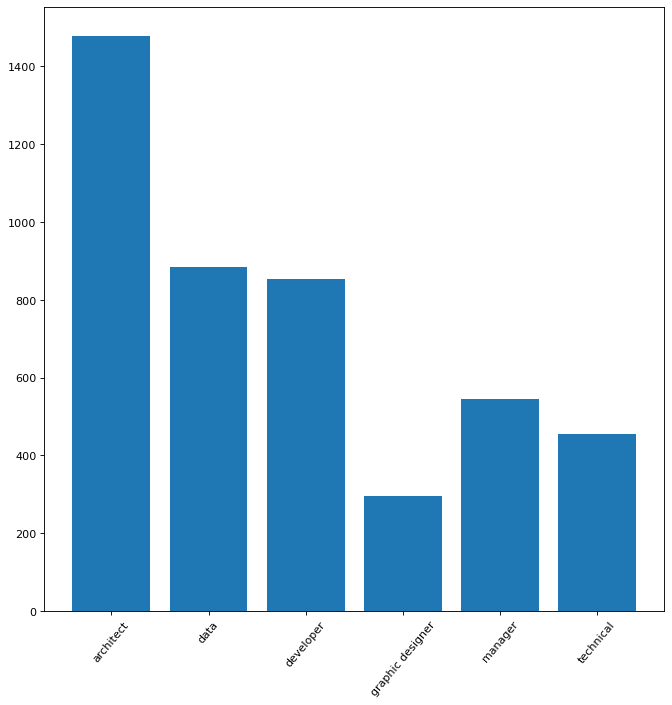

In [10]:
fig=plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
plt.bar(jobs.groupby('job_type').count()['job_title'].keys(), jobs.groupby('job_type').count()['job_title'].values)
ax.set_xticklabels(jobs.groupby('job_type').count()['job_title'].keys(), rotation=50)
plt.show()

### - Profile

In [11]:
profile.groupby('search').count()['name']

search
architect           278
data                200
developer           183
graphic designer     56
manager             149
technical           116
Name: name, dtype: int64

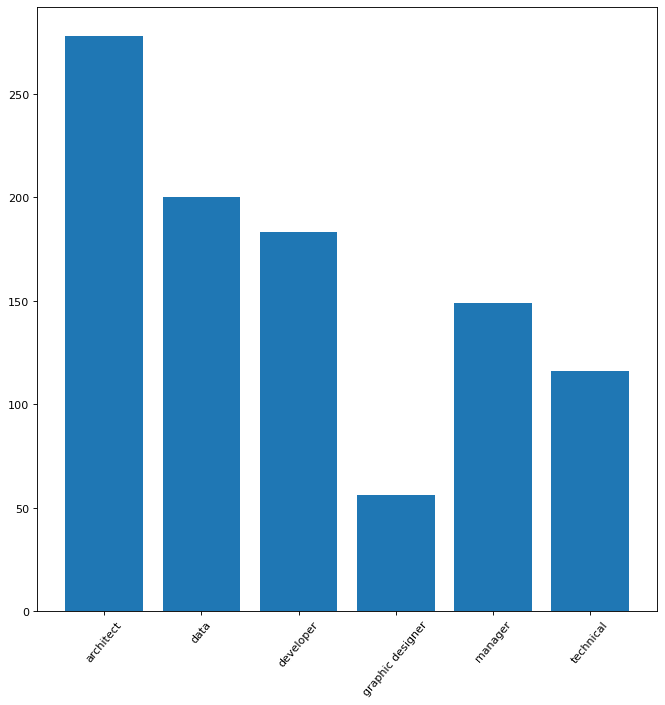

In [12]:
fig=plt.figure(figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
ax = fig.add_subplot(111)
plt.bar(profile.groupby('search').count()['name'].keys(), profile.groupby('search').count()['name'].values)
ax.set_xticklabels(profile.groupby('search').count()['name'].keys(), rotation=50)
plt.show()

https://towardsdatascience.com/multi-class-text-classification-model-comparison-and-selection-5eb066197568

## Data Proprocessing

In [13]:
stop_words = set(stopwords.words('english')) 
stemmer = WordNetLemmatizer()
lem = WordNetLemmatizer()

In [14]:
def clean_data(document):
    
    document = re.sub(r'\W', ' ', str(document))
    document = document.lower()
    
    # remove all single characters
    document = re.sub(r'\s+[a-zA-Z]\s+', ' ', document)
    
    #remove tags
    document = re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", document)
    
    # remove single characters from the start
    document = re.sub(r'\^[a-zA-Z]\s+', ' ', document) 
    
    # substituting multiple spaces with single space
    document = re.sub(r'\s+', ' ', document, flags=re.I)
    
    # remove hashtag #
    document = re.sub(r'#','',document) 
    
    # Converting to Lowercase
    document = document.lower()
    
    return document

In [15]:
# test = CountVectorizer(analyzer='word', ngram_range=(1, 2))
# test.fit_transform([jobs['desc'][0]])

In [16]:
def split_word(document):
    tokens = word_tokenize(clean_data(document))
    tokens = [i for i in tokens if not i in stop_words] # remove stop word
    tokens = [word for word in tokens if word.isalpha()] # remove alpha
    tokens = [i for i in tokens if not i.isnumeric()] # remove number
    tokens = [i for i in tokens if not ' ' in i] # remove space
    tokens = [stemmer.lemmatize(i) for i in tokens] # root
    
    document = ' '.join(tokens)
    return document

In [17]:
def plot_confusion_matrix(y_test, y_pred, labels, title):
    # plot confusion matrix
    confusion = confusion_matrix(y_test, y_pred, labels=labels)
    fig=plt.figure(figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
    ax = fig.add_subplot(111)
    sn.set(font_scale=1.4) # for label size
    sn.heatmap(confusion, annot=True, annot_kws={"size": 13}, fmt='d')
    ax.set_xticklabels(list(set(job_type_tokens)), rotation=50)
    ax.set_yticklabels(list(set(job_type_tokens)), rotation=50)
    plt.title(title)
    plt.show()

### Word2Vec  and Logistic Regression

In [18]:
# wv = gensim.models.KeyedVectors.load_word2vec_format("data/corpus/GoogleNews-vectors-negative300.bin.gz", binary=True)
# wv.init_sims(replace=True)

In [19]:
# def word_averaging(wv, words):
#     all_words, mean = set(), []
    
#     for word in words:
#         if isinstance(word, np.ndarray):
#             mean.append(word)
#         elif word in wv.vocab:
#             mean.append(wv.syn0norm[wv.vocab[word].index])
#             all_words.add(wv.vocab[word].index)

#     if not mean:
#         logging.warning("cannot compute similarity with no input %s", words)
#         # FIXME: remove these examples in pre-processing
#         return np.zeros(wv.vector_size,)

#     mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
#     return mean

# def  word_averaging_list(wv, text_list):
#     return np.vstack([word_averaging(wv, post) for post in text_list ])


# def w2v_tokenize_text(text):
#     tokens = []
#     text = split_word(text)
#     for sent in nltk.sent_tokenize(text, language='english'):
#         for word in nltk.word_tokenize(sent, language='english'):
#             if len(word) < 2:
#                 continue
#             tokens.append(word)
#     return tokens

In [20]:
# w2v_jobs_token = [w2v_tokenize_text(doc) for doc in jobs['desc']]
# w2v_jobs_word_avg = word_averaging_list(wv,w2v_jobs_token) # weight with corpus

In [21]:
# X_train, X_test, y_train, y_test = train_test_split(w2v_jobs_word_avg, jobs['job_type'], random_state=0, test_size=0.33)

In [22]:
# logreg_w2v = LogisticRegression(n_jobs=1, C=1e5, max_iter=2500, dual=False)
# logreg_w2v = logreg_w2v.fit(X_train, y_train)

# y_pred = logreg_w2v.predict(X_test)
# print('accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred,target_names=list(set(y_test))))

### Doc2Vec  and Logistic Regression

In [23]:
# from gensim.models import Doc2Vec
# from gensim.models.doc2vec import TaggedDocument
# from tqdm import tqdm
# from sklearn import utils
# import re
# tqdm.pandas(desc="progress-bar")

# def label_sentences(corpus, label_type):
#     """
#     Gensim's Doc2Vec implementation requires each document/paragraph to have a label associated with it.
#     We do this by using the TaggedDocument method. The format will be "TRAIN_i" or "TEST_i" where "i" is
#     a dummy index of the post.
#     """
#     labeled = []
#     for i, v in enumerate(corpus):
#         label = label_type + '_' + str(i)
#         labeled.append(TaggedDocument(v.split(), [label]))
#     return labeled

In [24]:
# X_train, X_test, y_train, y_test = train_test_split([split_word(job) for job in jobs['desc']], jobs['job_type'], random_state=0, test_size=0.3)
# X_train = label_sentences(X_train, 'Train')
# X_test = label_sentences(X_test, 'Test')
# all_data = X_train + X_test

In [25]:
# model_dbow = Doc2Vec(dm=0, vector_size=300, negative=5, min_count=1, alpha=0.065, min_alpha=0.065)
# model_dbow.build_vocab([x for x in tqdm(all_data)])

# for epoch in range(30):
#     model_dbow.train(utils.shuffle([x for x in tqdm(all_data)]), total_examples=len(all_data), epochs=1)
#     model_dbow.alpha -= 0.002
#     model_dbow.min_alpha = model_dbow.alpha

In [26]:
# def get_vectors(model, corpus_size, vectors_size, vectors_type):
#     """
#     Get vectors from trained doc2vec model
#     :param doc2vec_model: Trained Doc2Vec model
#     :param corpus_size: Size of the data
#     :param vectors_size: Size of the embedding vectors
#     :param vectors_type: Training or Testing vectors
#     :return: list of vectors
#     """
#     vectors = np.zeros((corpus_size, vectors_size))
#     for i in range(0, corpus_size):
#         prefix = vectors_type + '_' + str(i)
#         vectors[i] = model.docvecs[prefix]
#     return vectors
    
# train_vectors_dbow = get_vectors(model_dbow, len(X_train), 300, 'Train')
# test_vectors_dbow = get_vectors(model_dbow, len(X_test), 300, 'Test')

In [27]:
# logreg_doc2vec = LogisticRegression(n_jobs=1, C=1e5, max_iter=5000)
# logreg_doc2vec.fit(train_vectors_dbow, y_train)
# logreg_doc2vec = logreg_doc2vec.fit(train_vectors_dbow, y_train)
# y_pred = logreg_doc2vec.predict(test_vectors_dbow)
# print('accuracy %s' % accuracy_score(y_pred, y_test))
# print(classification_report(y_test, y_pred, target_names=list(set(y_test))))

### Train Test For Jobs

In [28]:
# Tokenize document
job_type_tokens = [doc.lower() for doc in jobs['job_type']]
jobs_tokens = [split_word(doc) for doc in jobs['desc']]

# Split train test data
X_train, X_test, y_train, y_test = train_test_split(jobs_tokens, job_type_tokens, test_size=0.33, random_state=42)

### TFIDF Modeling [SVM]

In [29]:
%%time
# Init SVM pipeline
svm_content = Pipeline([('vect', CountVectorizer(max_df=0.75, ngram_range=(1, 2))),
 ('tfidf', TfidfTransformer(use_idf=True)),
 ('clf-svm', CalibratedClassifierCV(SGDClassifier(random_state=42, loss='hinge')))])

# train model
svm_content.fit(X_train, y_train)

# save model to disk
pickle.dump(svm_content, open('model/svm_content.sav', 'wb'))

Wall time: 7.11 s


#### Report

In [30]:
svm_content_pred = svm_content.predict(X_test)
svm_content_prob = svm_content.predict_proba(X_test)
print(classification_report(y_test, svm_content_pred))

                  precision    recall  f1-score   support

       architect       0.92      0.92      0.92       476
            data       0.93      0.94      0.94       286
       developer       0.89      0.92      0.90       280
graphic designer       0.96      0.94      0.95       109
         manager       0.91      0.82      0.86       180
       technical       0.89      0.94      0.92       157

        accuracy                           0.92      1488
       macro avg       0.92      0.91      0.91      1488
    weighted avg       0.92      0.92      0.92      1488



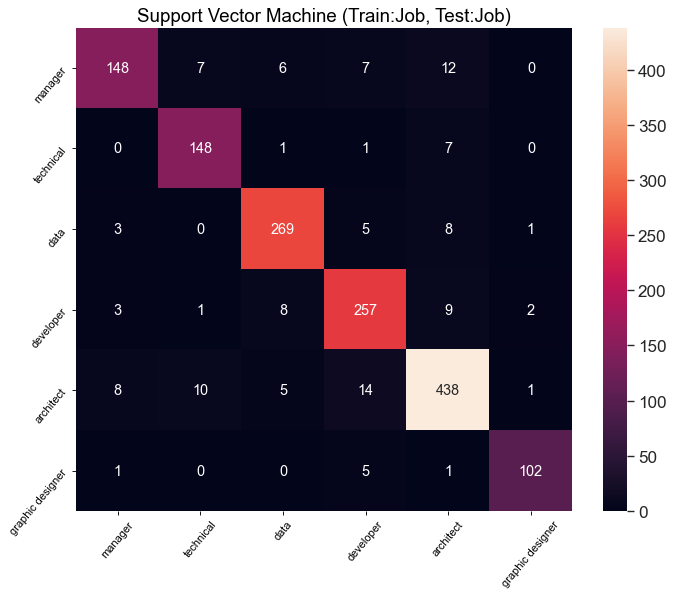

In [31]:
plot_confusion_matrix(y_test, svm_content_pred, list(set(job_type_tokens)), 'Support Vector Machine (Train:Job, Test:Job)')

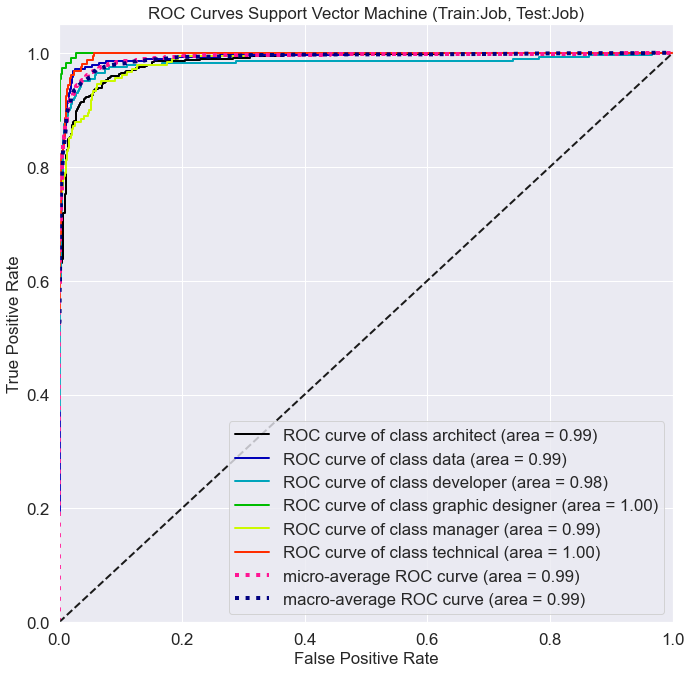

In [32]:
skplt.metrics.plot_roc(y_test, svm_content_prob, figsize=(11, 11))
plt.title("ROC Curves Support Vector Machine (Train:Job, Test:Job)")
plt.show()

### TFIDF Modeling [Logistic Regression] **

In [33]:
%%time
# init Logistic Regression Pipeline
logreg_content = Pipeline([('vect', CountVectorizer(max_df=0.75, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=-1, solver='lbfgs', C=1e5, random_state=42)),
               ])

# train model
logreg_content.fit(X_train, y_train)

# save model to disk
pickle.dump(svm_content, open('model/logreg_content.sav', 'wb'))

Wall time: 1min 14s


#### Report

In [34]:
logreg_content_pred = logreg_content.predict(X_test)
logreg_content_score = logreg_content.decision_function(X_test)
logreg_content_prob = logreg_content.predict_proba(X_test)

print(classification_report(y_test, logreg_content_pred))

                  precision    recall  f1-score   support

       architect       0.91      0.92      0.91       476
            data       0.92      0.93      0.93       286
       developer       0.90      0.91      0.91       280
graphic designer       0.98      0.94      0.96       109
         manager       0.90      0.79      0.84       180
       technical       0.88      0.92      0.90       157

        accuracy                           0.91      1488
       macro avg       0.92      0.91      0.91      1488
    weighted avg       0.91      0.91      0.91      1488



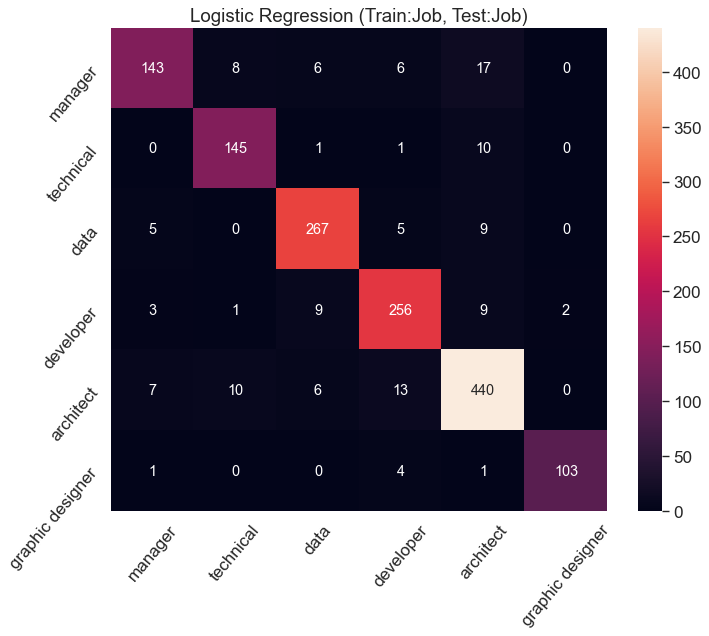

In [35]:
plot_confusion_matrix(y_test, logreg_content_pred, list(set(job_type_tokens)), 'Logistic Regression (Train:Job, Test:Job)')

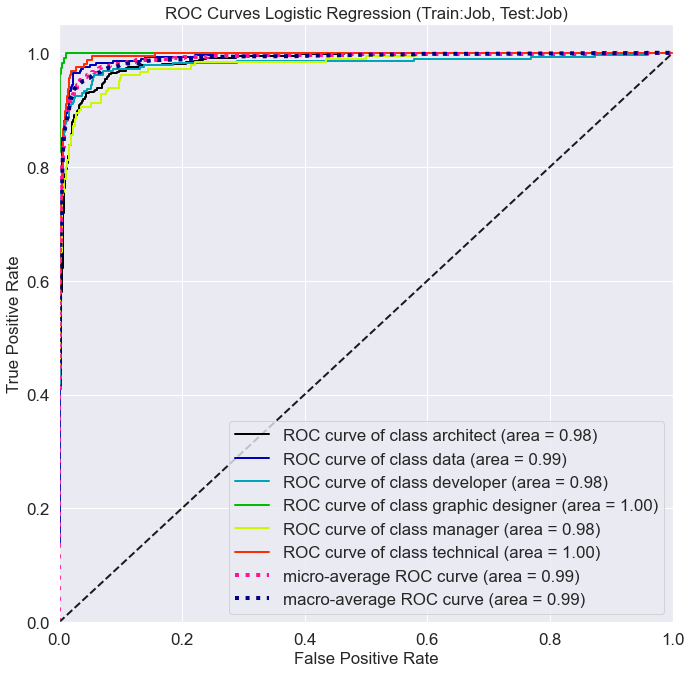

In [36]:
skplt.metrics.plot_roc(y_test, logreg_content_prob, figsize=(11, 11))
plt.title("ROC Curves Logistic Regression (Train:Job, Test:Job)")
plt.show()

# Predict Profile Data

In [37]:
# token word
profile_tokens = [split_word(doc) for doc in profile['skill']]

# Split train test profile data
X_train_profile, X_test_profile, y_train_profile, y_test_profile = train_test_split(profile_tokens, profile['search'], test_size=0.33, random_state=42)

#### Using Support Vector Machine Predict Profile

In [38]:
svm_profile_pred = svm_content.predict(X_test_profile)
svm_profile_prob = svm_content.predict_proba(X_test_profile)
print(classification_report(svm_profile_pred, y_test_profile))

                  precision    recall  f1-score   support

       architect       0.62      0.72      0.67        78
            data       0.88      0.81      0.84        93
       developer       0.96      0.66      0.79        80
graphic designer       0.88      0.83      0.86        18
         manager       0.60      0.59      0.60        49
       technical       0.23      1.00      0.38         7

        accuracy                           0.72       325
       macro avg       0.70      0.77      0.69       325
    weighted avg       0.78      0.72      0.74       325



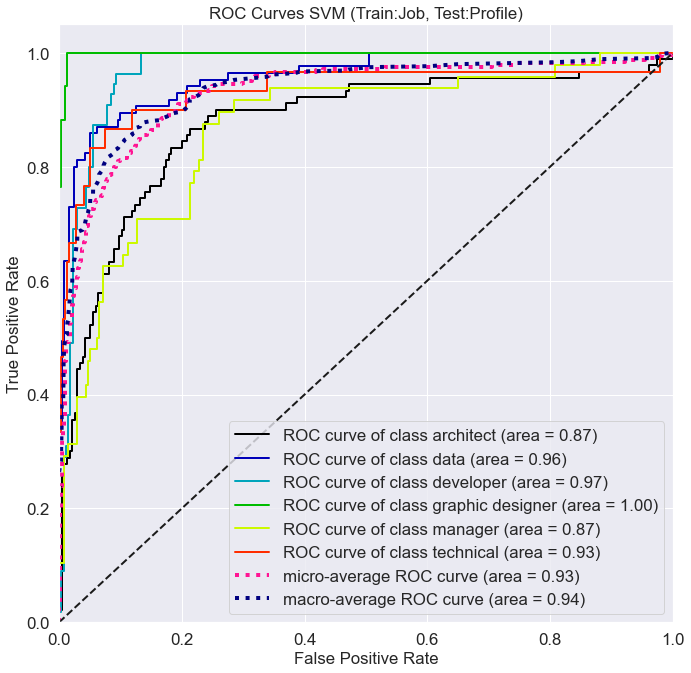

In [39]:
skplt.metrics.plot_roc(y_test_profile, svm_profile_prob, figsize=(11, 11))
plt.title("ROC Curves SVM (Train:Job, Test:Profile)")
plt.show()

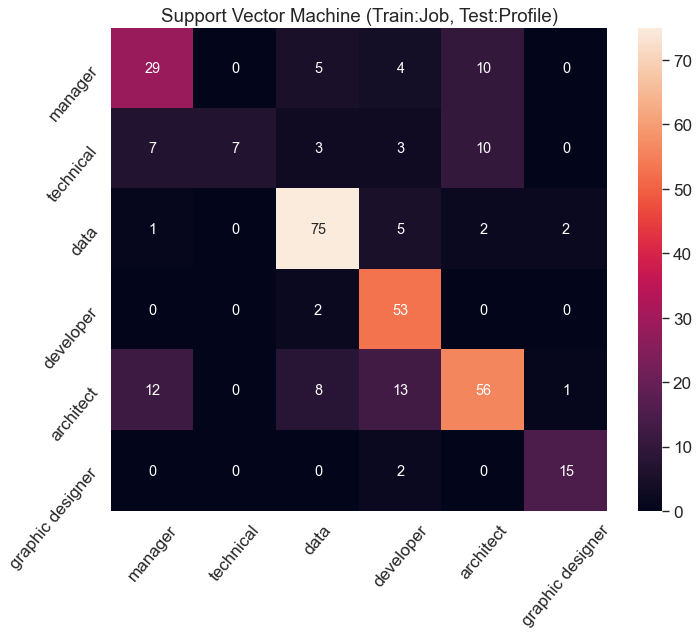

In [40]:
plot_confusion_matrix(y_test_profile, svm_profile_pred, list(set(y_test_profile)), 'Support Vector Machine (Train:Job, Test:Profile)')

#### Using Logistic Regression Predict Profile **

In [41]:
log_profile_pred = logreg_content.predict(X_test_profile)
log_profile_score = logreg_content.decision_function(X_test_profile)
log_profile_prob = logreg_content.predict_proba(X_test_profile)
print(classification_report(log_profile_pred, y_test_profile))

                  precision    recall  f1-score   support

       architect       0.64      0.72      0.68        81
            data       0.88      0.75      0.81       100
       developer       0.93      0.67      0.78        76
graphic designer       0.88      0.79      0.83        19
         manager       0.56      0.61      0.59        44
       technical       0.17      1.00      0.29         5

        accuracy                           0.71       325
       macro avg       0.68      0.76      0.66       325
    weighted avg       0.78      0.71      0.73       325



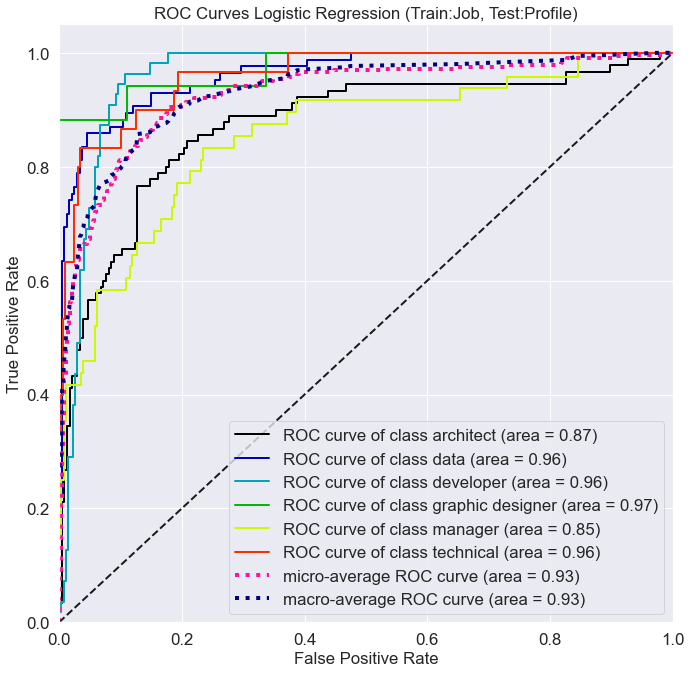

In [42]:
skplt.metrics.plot_roc(y_test_profile, log_profile_prob, figsize=(11, 11))
plt.title("ROC Curves Logistic Regression (Train:Job, Test:Profile)")
plt.show()

#### Report

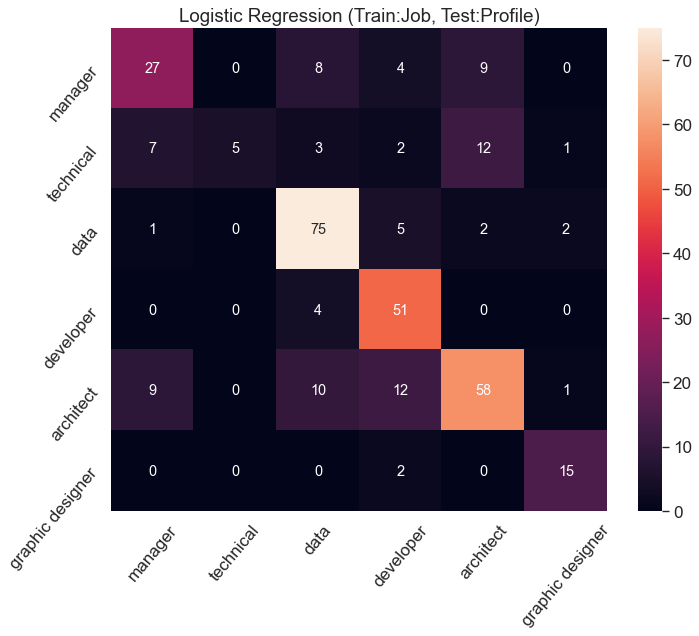

In [43]:
plot_confusion_matrix(y_test_profile, log_profile_pred, list(set(y_test_profile)), 'Logistic Regression (Train:Job, Test:Profile)')

# Collaborative Model

In [44]:
profile.groupby('search').count()['name']

search
architect           278
data                200
developer           183
graphic designer     56
manager             149
technical           116
Name: name, dtype: int64

#### Train & Predict usging Support Vector Machine

In [45]:
%%time
svm_colla = Pipeline([('vect', CountVectorizer(max_df=0.75, ngram_range=(1, 2))),
 ('tfidf', TfidfTransformer(use_idf=True)),
 ('clf-svm', CalibratedClassifierCV(SGDClassifier(random_state=42, loss='hinge')))])

# train model
svm_colla.fit(X_train_profile, y_train_profile)

# save model to disk
pickle.dump(svm_content, open('model/svm_colla.sav', 'wb'))

Wall time: 575 ms


#### Report

In [46]:
svm_colla_prob = svm_colla.predict_proba(X_test_profile)
svm_colla_pred = svm_colla.predict(X_test_profile)
print(classification_report(svm_colla_pred, y_test_profile))

                  precision    recall  f1-score   support

       architect       0.73      0.81      0.77        81
            data       0.92      0.91      0.91        86
       developer       0.84      0.78      0.81        59
graphic designer       0.94      1.00      0.97        16
         manager       0.67      0.68      0.67        47
       technical       0.77      0.64      0.70        36

        accuracy                           0.80       325
       macro avg       0.81      0.80      0.81       325
    weighted avg       0.81      0.80      0.80       325



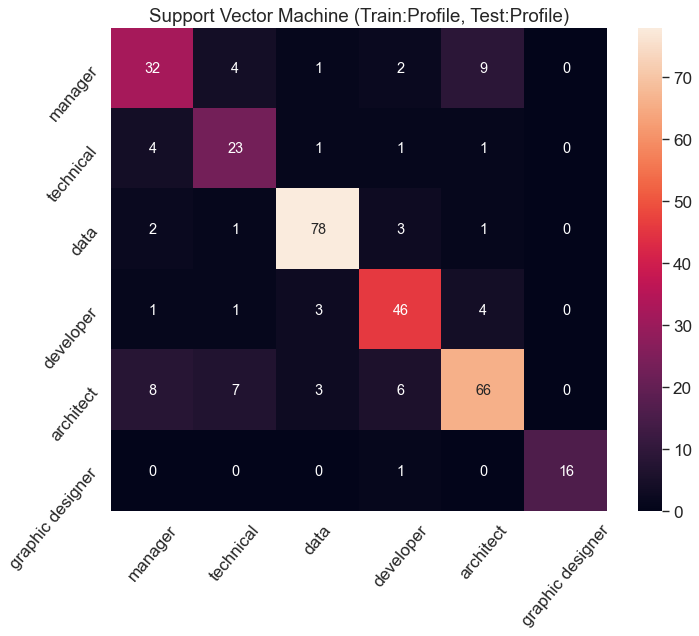

In [47]:
plot_confusion_matrix(y_test_profile, svm_colla_pred, list(set(y_test)), 'Support Vector Machine (Train:Profile, Test:Profile)')

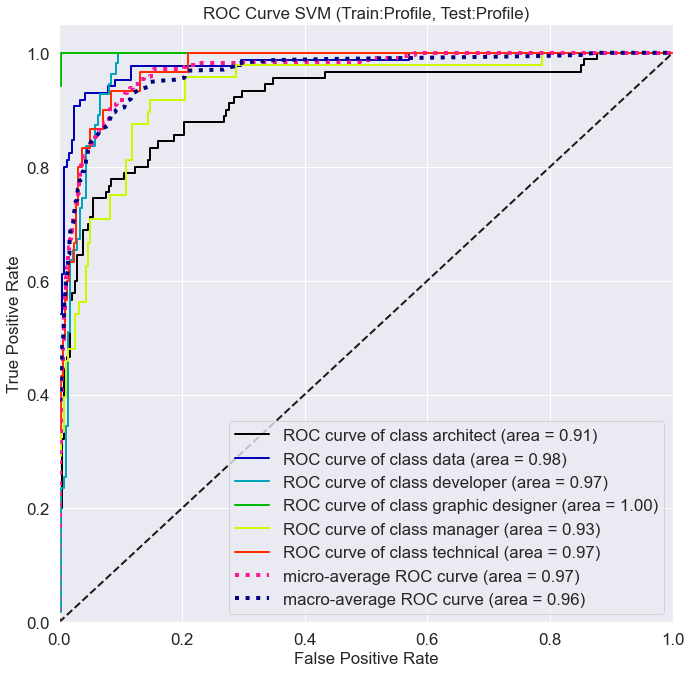

In [48]:
skplt.metrics.plot_roc(y_test_profile, svm_colla_prob, figsize=(11, 11))
plt.title("ROC Curve SVM (Train:Profile, Test:Profile)")
plt.show()

#### Train & Predict usging Logistic Regression

In [49]:
%%time
logreg_colla = Pipeline([('vect', CountVectorizer(max_df=0.75, ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=-1, solver='lbfgs', C=1e5, random_state=42)),
               ])

# train model
logreg_colla.fit(X_train_profile, y_train_profile)

# save model to disk
pickle.dump(svm_content, open('model/svm_colla.sav', 'wb'))

Wall time: 2.57 s


#### Report

In [50]:
logreg_colla_pred = logreg_colla.predict(X_test_profile)
logreg_colla_score = logreg_colla.decision_function(X_test_profile)
logreg_colla_prob = logreg_colla.predict_proba(X_test_profile)
print(classification_report(y_test_profile, logreg_colla_pred))

                  precision    recall  f1-score   support

       architect       0.79      0.74      0.77        90
            data       0.89      0.88      0.89        85
       developer       0.79      0.80      0.79        55
graphic designer       0.89      0.94      0.91        17
         manager       0.69      0.65      0.67        48
       technical       0.62      0.77      0.69        30

        accuracy                           0.79       325
       macro avg       0.78      0.80      0.79       325
    weighted avg       0.79      0.79      0.79       325



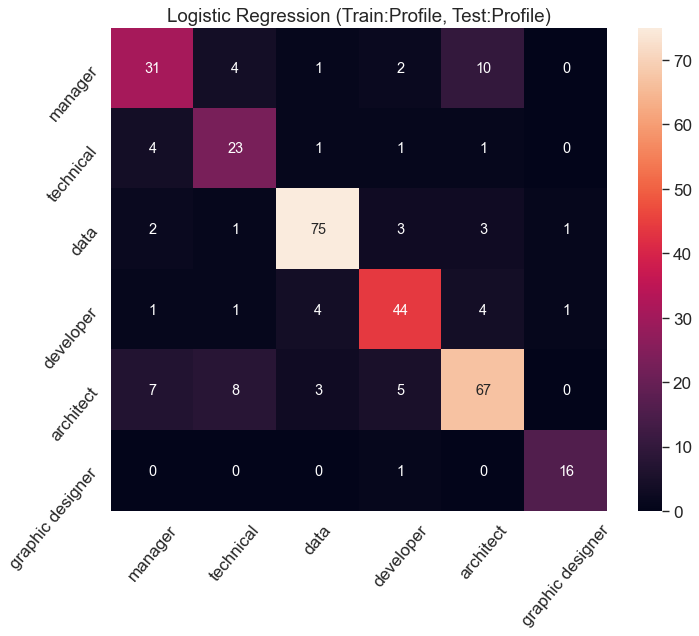

In [51]:
plot_confusion_matrix(y_test_profile, logreg_colla_pred, list(set(y_test)), 'Logistic Regression (Train:Profile, Test:Profile)')

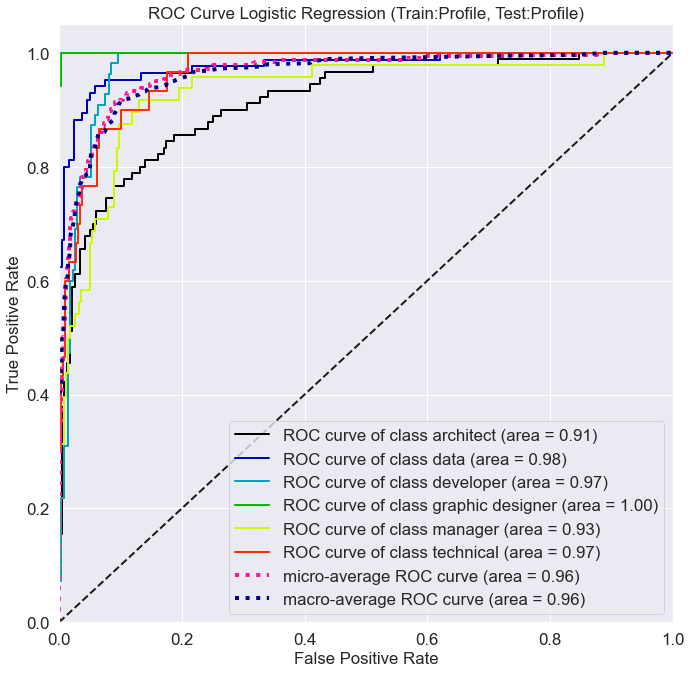

In [52]:
skplt.metrics.plot_roc(y_test_profile, logreg_colla_prob, figsize=(11, 11))
plt.title("ROC Curve Logistic Regression (Train:Profile, Test:Profile)")
plt.show()

## Predict Job Group

In [53]:
def top_n_pred(prob, labels, n):
    n_pred = np.argsort(prob, axis=1)[:,-n :]
    top_n = labels[n_pred]
    top_n = [' | '.join(item[::-1]) for item in top_n]
    return top_n

In [54]:
logreg_colla_top3 = top_n_pred(logreg_colla_prob, logreg_colla.classes_, 2)
logreg_content_top3 = top_n_pred(log_profile_prob, logreg_content.classes_, 2)

In [55]:
pred_profile = profile.iloc[y_test_profile.index.tolist()[:10]]
pred_profile = pred_profile[['name', 'skill']]

In [56]:
# create profile with predict data frame
profile_pred = pd.DataFrame({"job_type": y_test_profile[:10], "collaborative_pred": logreg_colla_top3[:10], "content_pred": logreg_content_top3[:10]})
profile_pred = pd.concat([pred_profile, profile_pred], axis=1)
profile_pred

,name,skill,job_type,collaborative_pred,content_pred
809,saharat petcharayuttapan,"swift,objective-c,object-oriented programming ...",developer,developer | manager,developer | graphic designer
800,prasittichai samngam,"java,javascript,java enterprise edition,node.j...",developer,developer | architect,developer | data
861,akapat bunyaratavej,"red hat linux,linux system administration,orac...",architect,architect | data,data | architect
497,supakrit nititsopon,"business analysis,data science,artificial inte...",data,data | developer,data | developer
67,chutchawan s.,"active directory,windows server,servers,techni...",architect,technical | architect,architect | manager
816,jirachaiphat chaichinvara,"internetworking,mobile applications,databases,...",developer,developer | data,developer | data
650,natthanon namnuae,"graphic design,web design,project management,p...",graphic designer,graphic designer | manager,graphic designer | developer
362,pierre de villecourt,"change management,outsourcing,program manageme...",manager,manager | architect,manager | data
493,pawit pharpatara,"path planning,matlab,java,aircraft,problem sol...",data,data | architect,developer | data
448,antoine sompheng,"sharepoint,microsoft sql server,microsoft offi...",architect,architect | technical,architect | data


## Job Matching
https://towardsdatascience.com/job-title-analysis-in-python-and-nltk-8c7ba4fe4ec6

https://www.ilo.org/wcmsp5/groups/public/---ed_emp/documents/presentation/wcms_721980.pdf

https://monkeylearn.com/keyword-extraction/

https://medium.com/analytics-vidhya/automated-keyword-extraction-from-articles-using-nlp-bfd864f41b34

In [57]:
def job_rank(job_distance, jobs, n):
    rank10 = jobs.iloc[job_distance.index.tolist()][:n].reset_index(drop=True)
    rank10['score'] = job_distance.values[:n]
    return rank10

In [58]:
def job_match(model, skill, jobs, n):
    
    profile_pred = model.predict(skill) # skill must be list
    
    # find job, profile distance in scope of predict field
    job_distance = []
    jobs_field = jobs[jobs['job_type'] == profile_pred[0]]
    
    for job in jobs_field['desc']:
        job_distance.append(cosine_distance_countvec(job, skill[0]))
    
    # create dataframe for index fixed
    job_distance = pd.DataFrame(job_distance)
    
    # sort distance
    job_distance = job_distance.sort_values(by=[0], ascending=False)
    
    return job_rank(job_distance, jobs_field, n)

In [59]:
def model_percent_weight(models_pred, y_test):
    models_acc = []
    models_percen = []
    
    for model in models_pred:
        models_acc.append(accuracy_score(model, y_test))
    
    for model in models_acc:
        models_percen.append(round(model / sum(models_acc), 3))
        
    return models_percen

In [60]:
def recommend(models, models_pred, skill, jobs, y_test, n):
    model_weight = model_percent_weight(models_pred, y_test)
    
    # get size of n by weight model acc
    n_weight = [round(weight* n / 100) for weight in model_weight]
    
    result = [job_match(model, skill, jobs, int(n_weight[index])) for index, model in enumerate(models)]
    result = pd.concat(result)
    result.sort_values(by=['score'], ascending=False, inplace=True)
    result.reset_index(drop=True, inplace=True)
    return result

In [61]:

def cosine_distance_countvec(s1, s2):
    
    count_vectorizer = CountVectorizer()
    sparse_matrix = count_vectorizer.fit_transform([s1, s2]).todense()
    
    s1 = sparse_matrix[0]
    s2 = sparse_matrix[1]
    cosine = distance.cosine(s1, s2)
    
    return 1 - cosine

In [62]:
def find_similar(skill, jobs, weight):
    print(jobs['desc'].shape)
    jobs['similar'] = [cosine_distance_countvec(job, skill) * weight for job in jobs['desc']]
    return jobs

In [63]:
def test_match(models, skill, jobs, y_pred, y_test, n):
    
    # profile "job type" by skill
    groups = [model.predict([split_word(skill)])[0] for model in models]
    
    # group jobs by "job type" of each model
    jobs_group = [jobs[jobs['job_type'] == group] for group in groups]
    
    # get weight of each model
    weight = model_percent_weight(y_pred, y_test)
    
    # find similar and weight
    jobs_similar = pd.concat([find_similar(skill[0], jobs, weight[index]) for index, jobs in enumerate(jobs_group)])
    jobs_similar = jobs_similar.drop_duplicates(subset="desc", keep='first')
    jobs_similar = jobs_similar[jobs_similar['similar'] != 0]
    jobs_sort = jobs_similar.sort_values(by=['similar'], ascending=False)
    return jobs_sort[:n]
            
    
    
    
#     jobs_group.drop_duplicates(subset="desc", keep='first', inplace=True)
    
#     return weight

In [64]:
# create jobs data frame with description clean
df_jobs_tokens = jobs.copy(deep=True)
df_jobs_tokens['desc'] = jobs_tokens

In [70]:
profile1 = ['vue.js, javascript, html, css, sql, firebase, php, mongodb, react.js, nuxt.js, python'] # web, mobile
profile2 = ['sql, business intelligence, project management, it risk management, business analysis']
profile3 = ['project management, people management, business analysis, planning, it strategy, it service management, it operations management, it infrastructure management, it management']
# profile2 = [profile[profile['search'] == 'architect']['skill'].iloc[1]] # security
# profile3 = [profile[profile['search'] == 'manager']['skill'].iloc[1]] # it management
# profile4 = [profile[profile['search'] == 'technical']['skill'].iloc[0]] # service
# profile5 = [profile[profile['search'] == 'developer']['skill'].iloc[0]] # service
# profile1_pred = logreg_colla.predict(profile1)
# profile2_pred = logreg_colla.predict(profile2)
# profile3_pred = logreg_colla.predict(profile3)
# profile1 = [profile.iloc[67]['skill']]

In [71]:
%%time
result = test_match([logreg_colla, logreg_content], profile1, df_jobs_tokens, [logreg_colla_pred, log_profile_pred], y_test_profile, 20)

(853,)


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


(853,)
Wall time: 1.46 s


c:\users\user\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [72]:
from IPython.display import Markdown, display
def printmd(string):
    display(Markdown(string))

In [74]:

for index, job in enumerate(result['desc']):
    current = result.iloc[index]
    printmd('**' + current.job_title + '**' + f" [ {round(current.similar, 3)} ]")
    print(job.replace("\n", " "), '\n')

**Freelance Web Developer** [ 0.081 ]

skill qualification extensive knowledge html cs javascript jquery knowledge php send resume hr department info firmdesign com 



**Web Developer** [ 0.077 ]

looking advanced web developer strong php mysql skill two plus year professional experience requested computer science college degree beneficial required skill php mysql html cs xml javascript angular j git svn beneficial skill java bootstrap cs io development android development encryption apache solr python 



**Software Engineer, React.js or C#** [ 0.071 ]

retained client start company dallas texas deliver software engineer work almost fully remote react j javascript skill net web api skill contract basis position working redesigning functionality fairly simple uis reactjs home grown redux like library using google map api position remote work anywhere continental united state initially position part time hour week fully remote however prefer candidate located dallas fort worth texas area attend developer meeting person north dallas remote work perfectly fine minor plus local dallas area software engineer working react j net web api part multi discipline team meaningful collaboration highly valued responsibility rooted design implementation application using react front end redux like library net backend visible customer employee position requires good interpersonal communication skill ability solve complex problem applicable technical experience ideal candidate self motivated individual true thirst knowledge action value cohesiveness ab

**Web Developer** [ 0.068 ]

job code i wd mandatory skill web server apache scripting language web technology php html java script cs tool html editor php editor template smarty template language mandatory database oracle mandatory 



**Web Developer** [ 0.065 ]

create web application help business consumer navigate taking making payment online looking productive developer experience help u develop product using rust ruby javascript postgresql prioritize excellent customer support time work customer help resolve issue understand feature requirement appropriate skill love linux system administration encourage pair programming share knowledge across project provide mentoring across skill level required qualification fluent front end web development html cs javascript familiarity node j npm familiarity ruby rail rubygems etc linux experience fedora primary o familiarity postgresql sql database familiarity rest mvc familiarity git github bitbucket gitlab year development experience desired qualification experience experience rust python php perl rust ruby python php perl go java familiar amazon web service etc familiar online payment processing 



**React developer** [ 0.062 ]

job detail position react developer hand experience responsive web design using bootstrap cs flexboxes medium query develop react j component form event key translate wireframes psd design functional web apps using react node j mongo bind ui element javascript object model create restful service node j 



**Frontend Developer** [ 0.061 ]

looking web developer experience taking photoshop design turning web ready product using le cs html javascript jquery candidate experience creating responsive website using front end framework bootstrap grunt experience php mvc framework laravel welcomed bonus apply please send u resume little bit link portfolio outstanding work would like brag mainly code html bootstrap le cs javascript jquery php smarty mysql great self motivated organized able manage project like work talented awesome people competitive salary full health benefit including dental laid back casual work environment dog friendly includes game room collaborative team spirit well regular company outing great tech setup everyone 



**JR. Software Engineer** [ 0.059 ]

jr software engineer responsible maintenance analysis design support current software development new software system solution meet changing need company education b m computer science equivalent field study required qualification excellent problem solving analytical skill ability think strategically logically ability work team environment ability prioritize perform multiple task simultaneously adhering deadline detail oriented strong work ethic curiosity passion software solution preferred experience language java javaee javascript cs html php perl python framework bootstrap uikit persistence mvc database mysql sql oracle pl sql operating system linux window location hampton va office position work home position report director company vice president compensation negotiable based experience paid vacation medical life insurance retirement benefit provided 



**PYTHON SOFTWARE ENGINEER-DEEP LEARNING, #10648** [ 0.058 ]

published may location anywhere united state america job type full time description title python software engineer deep learning job id location live anywhere united state remote work salary status direct hire contract client join loop client disrupting traditional market whole new way delivering structured data observation predictive analytics using deep learning technology python software engineer position looking python software engineer contribute back end development saas application enterprise client python software engineer responsibility responsible back end design development implementation machine learning software product translate business problem core product delivery contribute engineering tool infrastructure design analyze troubleshoot large scale distributed system python python software engineer requirement year experience python scripting language experience rest crud apis needed knowledge docker kubernetes sql nosql necessary familiarity behavior driven development b

**Web Developer** [ 0.057 ]

oneida esc group family company owned oneida nation wisconsin delivers customer focused engineering science construction service worldwide family company include oneida esc group oesc oneida total integrated enterprise otie mission support service sustainment restoration service sr oneida engineering solution oes integrate staff dedicated cooperative business like delivery service enhance customer mission sustainment restoration service sr firm provides engineering science construction munition specialized professional service solution customer nationwide sr immediate opening web developer united state military academy west point job duty writing well designed testable efficient code using best software development practice creating website layout user interface using standard html cs practice integrating data various back end service database responsibility full stack web application development variety language including ruby php javascript python implement user interface using html 

**Web Developer** [ 0.057 ]

application developer qualification proficiency working knowledge m sql server higher candidate must year experience web development language including cold fusion mx cfc html xhtml cs javascript sql xml etc working knowledge relational database design development implementation must knowledge ii m sql server enterprise manager also essential position job require graphic experience specifically adobe photoshop imageready ajax flash action script dhtml server network administration plus candidate must effective communicator well organized posse ability work fast paced environment 



**Web Developer - PHP** [ 0.057 ]

green fin technology looking php developer responsible creation implementation wide variety web based product using php javascript mysql ajax good understanding mvc shopping cart cm wordpress joomla magento etc payment gateway third party system integration added advantage 



**Sr. Web Applications Developer** [ 0.056 ]

sr web application developer bachelor deg yr exp f skill html cs javascript jquery angular j backbone j java python ajax json bootstrap intellij sublime text editor hp quality center agile methodology perforce involve phase software development life cycle sdlc participate design development testing implementation maintenance application responsible overall layout design troubleshooting product support create layout page using html cs javascript jquery develop non functional html cs page various business need improve user experience manage code using perforce git tortoise track bug using hp quality center involve code review send resume consulting victory blvd suite woodland hill ca interested career opportunity u please send cv cover letter hr consulting com get back right opportunity 



**Frontend Developer** [ 0.055 ]

depth interactive looking front end developer join web development team multiple web project developed given time looking someone interested different technology wanting work diverse set client position include working design ux group help create front end code using html cs javascript javascript interfacing directly rest backend single page application others compliment backend multipage website skill requirement great understanding javascript depth experience standard programming familiarity javascript framework specifically emberjs vuejs experience connecting rest based backend ability work designer create pixel perfect website html cs ability create rich mobile first site familiarity phonegap cordova plus benefit great vacation policy federal holiday health dental vision plan match remote working time snack drink coffee 



**Software Engineer, Frontend** [ 0.055 ]

forethought founded team facebook dropbox linkedin alumnus forethought mission enable everyone genius job building ai driven user experience embed information employee workflow starting ai solution customer support agent agatha forethought raised vc funding top investor including new enterprise associate nea village global venture firm backed mark zuckerberg bill gate reid hoffman venture ceo robinhood front carta forethought launched techcrunch disrupt world prestigious startup competition featured forbes building future unstructured information enterprise tackling market opportunity assembling world class team help u get role member front end team responsible developing user facing product feature platform forethought build feature ranging beautiful search tool worker integrated zendesk slack chrome apps tech stack leverage modern technology react j python flask mongodb early member team work cross functionally design product back end team build beautiful elegant product complex prob

**Software Engineer** [ 0.054 ]

role tql seeking full stack developer help develop maintain current business application web service use web development skill develop application service support many internal application position enrich web development skill give opportunity work latest technology competitive compensation benefit package advancement opportunity structured career path flexible work hour work home option access latest emerging technology microsoft partnership pluralsight subscription reimbursement continuous education technical training develop new solution asp net asp mvc html cs javascript angularjs react framework microsoft sql server build restful web service support ever growing service layer support new refactored website support maintain existing web application troubleshooting issue arise recommending improvement test document new application change work project owner analyst system design determine need plan solution communicate team member project owner team regarding project progress issue r

**Junior Web Developer – Wordpress, PHP** [ 0.054 ]

retained client fort worth texas deliver junior web developer php wordpress skill full time direct hire basis immediate hire right candidate junior developer looking naturally wordpress experience php experience backend issue dns also javascript cs html client several project cooking need additional web developer wordpress php background maybe year experience person fort worth manufacturer sell product online high demand producing excellent revenue commerce experience required suggested year php wordpress experience year necessary position knowledge troubleshoot backend issue example domain name server dns javascript cs html position full time site fort worth good benefit inside small growing company support web development team member internally house marketing company front end person web developer busy system integration initially work php wordpress future position could lead direction wordpress woocommerce employment type full time direct hire salary per year salary range depends u

**Web Application Developer** [ 0.053 ]

job description ideal candidate proven web development experience php must familier phase software development life cycle knowledge skill must good knowledge work experaince following tool technology html javascript jquery cs bootstrap php mysql excellent database development administration skill good understanding soap rest apis good understanding web hosting sps equal opportunity employer drug free workplace 



**Trainee Software Engineer** [ 0.051 ]

job detail description requirement qualification graduate e tech mca le experience fresher wish pick career opportunity eligible apply must knowledge oops sql scala asp net javascript html cs typescript etc must basic technical knowledge strong analytical problem solving skill highly motivated sense ownership accountability 



**WEB DEVELOPER** [ 0.051 ]

location scottsdale arizona pay rate competitive pay doe report ceo lead graphic designer benefit medical dental vision available character creative focused detail oriented motivated problem solver team player description looking well rounded web developer construct idea functional usable product also front line ensuring stability site always looking forward new technology require push boundary web development responsibility coordinate team member produce functional well constructed product develop additional functionality magento commerce platform creation user interface using html cs javascript php best practice usability mind manage project task stay predefined timeline perform routine site maintenance must have working knowledge html cs javascript php experience magento commerce platform passion web development strong attention detail creative problem solving skill previous experience wordpress source control experience server administration linux apache aws mysql understanding obj